### Import Libraries

In [ ]:
# Import necessary libraries
import glob
import os
from PIL import Image
import numpy as np
import pandas as pd
import scipy.io as sio
import matplotlib.pyplot as plt
import cv2
from matplotlib.patches import Rectangle
import seaborn as sns
from sklearn.model_selection import train_test_split
import os

import keras
import tensorflow as tf
from tensorflow.image import extract_patches
from tensorflow.keras import layers, Model, optimizers, regularizers
import tensorflow.keras.backend as K
from tensorflow.keras.utils import Sequence
from tensorflow.python.ops.numpy_ops import np_config
np_config.enable_numpy_behavior()

### Update Directory and Settings

In [ ]:
# Set the directory to the ViT Dataset folder that contains the dataset files and weights for saved models
directory = "/content/gdrive/MyDrive/ViT Dataset/"
os.chdir(directory)

# Set configurations for user defined functions
tf.config.run_functions_eagerly(True)
tf.data.experimental.enable_debug_mode()

### PatchProcess Class
This Class is a sub-class of the Keras.layers.Layer Class. It takes in the images in numpy format and converts them to patches. Then applies positional embedding to these patches. Finally, it is projected linearly into a Dense layer.

In [ ]:
class PatchProcess(layers.Layer):
  # Constructor to initialize values
  def __init__(self, n_patches, img_size=144, **kwargs):
      super(PatchProcess, self).__init__()
      self.n_patches = n_patches

      # If weights need to be learnt during training, it needs to be defined as a Class variable
      self.embed = layers.Embedding(self.n_patches*self.n_patches, 128)
      self.dense1 = layers.Dense(units=128)
      

  # Get config function is required for saving the model with configurations
  def get_config(self):
      config = super().get_config()
      config.update({
          "n_patches": self.n_patches
      })
      return config
  
  # This function is called when used as Keras functional API
  def call(self, img_arr):
      img_size = 144
      p_size = int(img_size/self.n_patches)   # Patch size
      b_size = tf.shape(img_arr)[0]   # Batch Size

      # Extract patches from the image array
      patches = tf.image.extract_patches(img_arr,
          sizes=[1, p_size, p_size, 1],
          strides=[1, p_size, p_size, 1],
          rates=[1, 1, 1, 1],
          padding='VALID')
      patches = tf.reshape(patches, [b_size, -1, patches.shape[-1]])

      # Linear projection
      dense1 = self.dense1(patches)

      # Learnable embedding
      pos = np.array(range(0,self.n_patches*self.n_patches))
      pos_embed = self.embed(pos) # 128 is output dim from linear projection layer
      pos_embed = tf.expand_dims(pos_embed,0)
      linear_proj = pos_embed + dense1
      return(linear_proj)
    

### ViT Class
This is the Vision transformer class that contains functions to get dataset, build network, fit the model and predict output

In [ ]:
class ViT():

  # Initialize variables
  def __init__(self):

    # Model variables
    self.opt = tf.optimizers.Adam(learning_rate = 0.001)
    self.loss_fn = keras.losses.MeanSquaredError()
    self.batch_size = 64
    self.epochs = 20

    # Dataset variables
    self.dataset = None
    self.y = None
    self.x_train = None
    self.x_val = None
    self.x_test = None
    self.y_train = None
    self.y_val = None
    self.y_test = None
    self.model = None

    # Output variables
    self.loss_values = None
    self.val_loss_values = None
    self.training_iou = None
    self.val_iou = None

    # Network Variables
    self.mlp_block_reg = None
    self.mlp_head_reg = None
    self.num_heads = 3
    self.img_size = 144
    self.n_patches = 6

  # Load the dataset
  def get_dataset(self):
    self.dataset = np.load("dataset_101.npy")
    self.y = np.load("y_101.npy")

    # Normalization
    self.dataset = self.dataset/255.

    # For stratification of categories
    y_copy = np.load("y_copy_101.npy", allow_pickle=True)
    type_list = []
    for val in y_copy:
        type_list.append(val[1])
    type_list = np.array(type_list)

    # Train test split
    self.x_train, self.x_test, self.y_train, self.y_test = train_test_split(self.dataset, self.y, test_size=0.15, stratify=type_list, random_state=10)
    train_type_list, test_type_list = train_test_split(type_list, test_size=0.15, stratify=type_list, random_state=10)
    self.x_train, self.x_val, self.y_train, self.y_val = train_test_split(self.x_train, self.y_train, test_size=self.x_test.shape[0], stratify=train_type_list, random_state=10)
    train_type_list, val_type_list = train_test_split(train_type_list, test_size=test_type_list.shape[0], stratify=train_type_list, random_state=10)
  
  # Tensorflow eager execution function that calculates Intersection over Union as a metric
  @tf.function
  def iou(self, pred, actual):
    pred = pred[0]
    actual = actual[0]

    # Get intersection coordinates
    left_x_con = max(pred[0], actual[0])
    top_y_con = min(pred[1], actual[1])
    bottom_y_con = max(pred[2], actual[2])
    right_x_con = min(pred[3], actual[3])

    # Calculate the area of the boxes
    area_intersect = abs((right_x_con - left_x_con)*(top_y_con - bottom_y_con))
    area_pred = abs((pred[3] - pred[0])*(pred[1] - pred[2]))
    area_actual = abs((actual[3] - actual[0])*(actual[1] - actual[2]))

    # Get IoU
    area_union = area_pred + area_actual - area_intersect
    ratio_inter_union = area_intersect/area_union
    if ratio_inter_union <0:
        ratio_inter_union=0
    return(ratio_inter_union)

  # Function that initializes and builds the network architecture
  def build_network(self):
    start = layers.Input(shape=(self.img_size,self.img_size,3))

    # Get linear projection of patches using the PatchProcess class
    linear_proj = PatchProcess(n_patches=self.n_patches)(start)

    # Normalization
    enc1 = layers.LayerNormalization()(linear_proj)

    # Multi Headed Attention
    mha = layers.MultiHeadAttention(num_heads=self.num_heads, key_dim=128, dropout=0.1)(enc1, enc1)

    # Residual input from positional embedding added
    enc2 = layers.Add()([linear_proj, mha])

    # Normalization
    enc3 = layers.Normalization()(enc2)

    # MLP
    enc3 = layers.Dense(128, activation='relu', kernel_regularizer=self.mlp_block_reg)(enc2)
    enc3 = layers.Dense(128, activation='relu', kernel_regularizer=self.mlp_block_reg)(enc3)

    # Residual from node after MHA added
    enc4 = layers.Add()([enc2, enc3])
    enc4 = layers.LayerNormalization()(enc4)
    enc4 = layers.Flatten()(enc4)
    enc4 = layers.Dropout(0.1)(enc4)

    # MLP Head
    mlp = layers.Dense(512, activation='relu', kernel_regularizer=self.mlp_head_reg)(enc4)
    #mlp = layers.Dropout(0.1)(mlp)
    mlp = layers.Dense(256, activation='relu', kernel_regularizer=self.mlp_head_reg)(mlp)
    #mlp = layers.Dropout(0.1)(mlp)
    mlp = layers.Dense(128, activation='relu', kernel_regularizer=self.mlp_head_reg)(mlp)
    #mlp = layers.Dropout(0.1)(mlp)
    mlp = layers.Dense(32, activation='relu', kernel_regularizer=self.mlp_head_reg)(mlp)
    #mlp = layers.Dropout(0.1)(mlp)
    out = layers.Dense(4)(mlp)

    self.model = Model(inputs=start, outputs=out)

  # Update network parameters using the below function
  def update_network_parameters(self, n_patches=None, mlp_block_reg=None, mlp_head_reg=None, num_heads=None):
    if n_patches!=None:
      self.n_patches = n_patches
    if mlp_block_reg!=None:
      self.mlp_block_reg = mlp_block_reg
    if mlp_head_reg!=None:
      self.mlp_head_reg = mlp_head_reg
    if num_heads!=None:
      self.num_heads = num_heads
    
  # Update model hyperparameters using the below function
  def update_parameters(self, epochs=None, batch_size=None, metrics=None, opt=None, loss_fn=None):
    if epochs!=None:
        self.epochs = epochs
    if batch_size!=None:
        self.batch_size = batch_size
    if metrics!=None:
        self.metrics = metrics
    if opt!=None:
        self.opt = opt
    if loss_fn!=None:
        self.loss_fn = loss_fn

  # Fit the model
  def fit(self):
    self.model.compile(optimizer=self.opt, loss=self.loss_fn, metrics=self.iou)
    history = self.model.fit(self.x_train, self.y_train,
                        batch_size=self.batch_size, 
                        epochs=self.epochs, 
                        validation_data=(self.x_val, self.y_val))
  
  # Update the values of Loss and IoU for plotting the graph
  def update_val(self):
    history = self.model.history.history
    self.loss_values = history['loss']
    self.val_loss_values = history['val_loss']
    self.training_iou = history['iou']
    self.val_iou = history['val_iou']

  # Train the model with training and validation sets
  def fit_full(self, verbose=0):
    x_train_full = np.vstack([self.x_train, self.x_val])
    y_train_full = np.vstack([self.y_train, self.y_val])  
    self.model.compile(optimizer=self.opt,
          loss=self.loss_fn,
        metrics=self.iou
          )
    self.model.fit(x_train_full, y_train_full, batch_size=self.batch_size, epochs=self.epochs, verbose=verbose)

  # Plot the MSE and IoU curves
  def plot(self):
    epochs_list=range(1, len(self.loss_values)+1)
    fig, ax = plt.subplots(1,2, figsize=(12, 5), squeeze=False)
    axli = ax.flatten()
    sns.lineplot(x=epochs_list, y=self.loss_values, ax=axli[0], legend='brief', label="Training Loss", linewidth=2)
    sns.lineplot(x=epochs_list, y=self.val_loss_values, ax=axli[0], legend='brief', label="Validation Loss", linewidth=2)
    axli[0].set(title="Mean Squared Error", xlabel='Epochs', ylabel='MSE')

    sns.lineplot(x=epochs_list, y=self.training_iou, ax=axli[1], legend='brief', label="Training IOU", linewidth=2)
    sns.lineplot(x=epochs_list, y=self.val_iou, ax=axli[1], legend='brief', label="Validation IOU", linewidth=2)
    axli[1].set(title="IoU", xlabel='Epochs', ylabel='IoU')
    plt.show()

  # Load a saved model
  def load_model(self, model_file):
    self.model = tf.keras.models.load_model(model_file, compile = False, custom_objects={'PatchProcess': PatchProcess})
    self.model.compile(optimizer=self.opt, loss=self.loss_fn, metrics=self.iou)
  
  # Evaluate the model
  def evaluate(self):
    return(self.model.evaluate(self.x_test, self.y_test))
  
  # Predict the output bounding boxes
  def predict(self):
    return(self.model.predict(self.x_test))

### Predict Bounding Box
The below function can be used to plot the actual and predicted bounding box for any one image

In [ ]:
def iou_(pred, actual):
    left_x_con = max(pred[0], actual[0])
    top_y_con = min(pred[1], actual[1])
    bottom_y_con = max(pred[2], actual[2])
    right_x_con = min(pred[3], actual[3])

    area_intersect = abs((right_x_con - left_x_con)*(top_y_con - bottom_y_con))
    area_pred = abs((pred[3] - pred[0])*(pred[1] - pred[2]))
    area_actual = abs((actual[3] - actual[0])*(actual[1] - actual[2]))

    area_union = area_pred + area_actual - area_intersect
    ratio_inter_union = area_intersect/area_union
    if ratio_inter_union <0:
      ratio_inter_union=0
    return(ratio_inter_union)

def predict_bounding_box(image_file, an_file, loaded_model):
    img_size = 144
    im = Image.open(image_file)
    w_size = im.size[0]
    h_size = im.size[1]
    img = im.resize((img_size,img_size))
    img = tf.keras.utils.img_to_array(img)
    img = tf.expand_dims(img, 0)
    pred = loaded_model.predict(img)[0]
    pred[0] = pred[0]*w_size
    pred[1] = pred[1]*h_size
    pred[2] = pred[2]*h_size
    pred[3] = pred[3]*w_size
    w = pred[3] - pred[0]
    h = pred[1] - pred[2]
    plt.imshow(np.flipud(im), origin='lower')

    ax = plt.gca()
    rect = Rectangle((pred[0], pred[2]), w, h, facecolor='none', edgecolor='r')
    ax.add_patch(rect)
    
    actual = sio.loadmat(an_file)
    actual = actual['box_coord'][0]
    actual = np.array(actual, dtype='float32')

    w_a = actual[3] - actual[0]
    h_a = actual[1] - actual[2]
    rect_a = Rectangle((actual[0], actual[2]), w_a, h_a, facecolor='none', edgecolor='g')
    
    ax.add_patch(rect_a)
    plt.legend(["Pred", "Act"])
    plt.show()

1/1 [==============================] - 0s 397ms/step


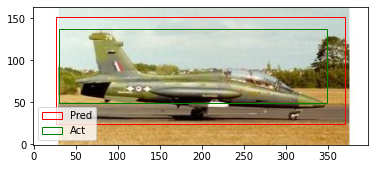

In [ ]:
# The below code plots the actual and predicted bounding box for any one image
nn = ViT()
nn.load_model("ViT_test_full.h5")  # Ensure the weights are in the current directory. If not change the directory
dir = directory  # Set the directory if needed
num = "001"   # Enter image number as string from '001' to '040' (some categories go upto 800)
category = "airplanes"    # Enter any category that is present as file name in the dataset
image_file = dir + "101_ObjectCategories/" + category + "/image_0" + str(num)+".jpg"
an_file = dir + "Annotations/" + category + "/annotation_0" + str(num)+".mat"
predict_bounding_box(image_file, an_file, nn.model)   # Ensure that nn.model is loaded

### Appendix

#### Appendix 1 - Get dataset.npy and y.npy files
Code to get the dataset.npy and y.npy files

In [ ]:
# Set the directory below in order to run this block of code
dataset = []
y = []
y_copy = []
img_size = 144
length = 0
greyscale = 0
image_list = os.listdir(directory) # change directory here if needed
an_list = os.listdir(directory)  # change directory here if needed
for image_categ, an_categ in zip(image_list, an_list):
    #print("start")
    image_path = directory + "101_ObjectCategories/" + image_categ + "/*.jpg"  # change directory here
    an_path = directory + "Annotations/" + an_categ + "/*.mat"  # change directory here
    sub_image_list = glob.glob(image_path)
    sub_image_list.sort()
    sub_an_list = glob.glob(an_path)
    sub_an_list.sort()
    for image_file, an_file in zip(sub_image_list, sub_an_list):
        im = Image.open(image_file)
        w = im.size[0]
        h = im.size[1]
        im = im.resize((img_size,img_size))
        im = tf.keras.utils.img_to_array(im)
        #print(im.shape)
        if im.shape == (img_size,img_size,3):
            dataset.append(im)
            length = length+1
            an = sio.loadmat(an_file)
            an = an['box_coord'][0]
            y_copy.append(an)
            an = np.array(an, dtype='float32')

            an[3] = an[3]/w
            an[0] = an[0]/w
            an[2] = an[2]/h
            an[1] = an[1]/h
            y.append(an)
        else:
            greyscale +=1
print(greyscale)

In [ ]:
# Convert to numpy array
dataset = np.array(dataset, dtype='float32')
y = np.array(y, dtype='float32')
print(dataset.shape)
print(y.shape)
np.save("101.npy", dataset)
np.save("101_y.npy", y)

#### Appendix 2 - Predict by Category
The below set of blocks can be used to get the predicted IoU by category

In [ ]:
nn = ViT()
nn.get_dataset()
nn.load_model("ViT_test_full.h5")

In [ ]:
# Set the directory below in order to run this block of code
img_size = 144
file_list = []
image_list = os.listdir(directory) # change directory here
an_list = os.listdir(directory)  # change directory here
for image_categ, an_categ in zip(image_list, an_list):
    #print("start")
    image_path = directory + "101_ObjectCategories\\" + image_categ + "\\*.jpg"  # change directory here
    an_path = directory + "Annotations\\" + an_categ + "\\*.mat"   # change directory here
    for image_file, an_file in zip(glob.glob(image_path), glob.glob(an_path)):
        im = Image.open(image_file)
        w = im.size[0]
        h = im.size[1]
        im = im.resize((img_size,img_size))
        im = tf.keras.utils.img_to_array(im)
        if im.shape == (img_size,img_size,3):
            #length = length+1
            an = sio.loadmat(an_file)
            an = an['box_coord'][0]
            #y_copy.append(an)
            an = np.array(an, dtype='float32')

            an[3] = an[3]/w
            an[0] = an[0]/w
            an[2] = an[2]/h
            an[1] = an[1]/h
            file_list.append([image_file, an, image_categ])


In [ ]:
df = pd.DataFrame(file_list, columns=["X", "Y", "Type"])
data, test = train_test_split(df, test_size = 0.15, stratify=df["Type"], random_state=10)
test = test.reset_index(drop=True)
img_size = 144
pred_out = []
for i in range(test.shape[0]):
    if(i%100)==0:
        print(i)
    im = Image.open(test.loc[i, "X"])
    w = im.size[0]
    h = im.size[1]
    img = im.resize((img_size,img_size))
    img = tf.keras.utils.img_to_array(img)
    if img.shape == (img_size,img_size,3):
        img = tf.expand_dims(img, 0)
        pred = nn.model.predict(img)[0]
        an = sio.loadmat(test.loc[i, "Y"])
        an = an['box_coord'][0]
        an = np.array(an, dtype='float32')
        an[3] = an[3]/w
        an[0] = an[0]/w
        an[2] = an[2]/h
        an[1] = an[1]/h
        y_act = an.copy()
        iou_val = iou_(pred, y_act)
        pred_out.append([test.loc[i, "Type"]])
        

In [ ]:
pred_df = pd.DataFrame(pred_out, columns=['Type', 'IOU'])
out = pred_df.groupby("Type")['IOU'].agg({'mean', 'count'})
out['Type'] = out.index
out = out.reset_index(drop=True)
out.head()

#### Appendix 3 - Custom Data Generator

In [ ]:
# Data generator built but not used due to conflicts with tensorflow eager execution
class DataGenerator(Sequence):
    def __init__(self, batch_size, path_file_x, path_file_y):
        self.batch_size = batch_size
        self.path_file_x = path_file_x
        self.path_file_y = path_file_y

    def __len__(self):
        return int(np.ceil(self.path_file_x.shape[0]/ float(self.batch_size)))

    def __getitem__(self, idx):
      batch_x = []
      sub_batch_x = self.path_file_x[idx * self.batch_size:(idx + 1) * self.batch_size]
      batch_y = self.path_file_y[idx * self.batch_size:(idx + 1) * self.batch_size]
      img_size = 144
      sub_path_file = self.path_file_x[idx]
      for i in range(len(idx)-1):
          im = Image.open(sub_path_file[i])
          w = im.size[0]
          h = im.size[1]
          im = im.resize((img_size,img_size))
          im = tf.keras.utils.img_to_array(im)
          assert(im.shape == (img_size, img_size, 3))
          batch_x.append(im)
      #batch_y = tf.convert_to_tensor(path_file[idx])
      #batch_x = tf.convert_to_tensor(batch_x)
      batch_y = self.path_file_y[idx]
      return batch_x, batch_y

### -----Test------
Run the sections:
- Import Libraries
- Update Directory and Settings
- PatchProcess Class
- ViT Class  
Then proceed to test the below blocks of code.  
If only the final weights are to be tested move to the last block

In [ ]:
# Initialize the object of the ViT Class
nn = ViT()


In [ ]:
# Get the dataset
nn.get_dataset()

In [ ]:
# Build the network
nn.build_network()

In [ ]:
# update network parameters below if needed (or leave it as None)
nn.update_network_parameters(n_patches=6, # Number of patches
                             mlp_block_reg=None, # Kernel regularization for MLP Block
                             mlp_head_reg=None, # Kernel regularization for MLP Head
                             num_heads=3  # Number of heads in Multi-head attention block
                             )
nn.build_network()

In [ ]:
# Update model hyperparameters if needed (or leave it as None)
nn.update_parameters(epochs=3, batch_size=64, metrics=None, opt=None, loss_fn=None)

In [ ]:
# Fit the model and plot the graphs
nn.fit()
nn.update_val()
nn.plot()

In [ ]:
# Evaluate and predict the model
nn.evaluate()
preds = nn.predict()

#### Test the saved weights directly
Run this block of code if only the test accuracy needs to be verified using saved weights  
If not already executed, please run the sections:
- Import Libraries
- Update Directory and Settings
- PatchProcess Class
- ViT Class 

In [ ]:
# Load a saved model and test the output
nn = ViT()
nn.get_dataset()
nn.load_model("ViT_test_full.h5")
nn.evaluate()

### References
Please note that all the libraries imported in the first block of code are not written by me and sourced online